# Graph network model denoiser for denoising thermal perturbation

This notebook will guide you through training and applying a graph network model for denoising thermal perturbation in crystal structures.

You will need to install `ase` for the convenience of reading and writing atomic structure files.

Being research code, `graphite` currently has no strict versioning. This notebook was last run on 2023-04-17. Please contact the authors if you encounter errors or bugs.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import ase.io

## Read/construct ideal structures

The model will be trained with noised datatset based on ideal (clean) reference lattices. But you only have to define the ideal structures here. We will use a custom `Dataset` class to automatically apply a random noise to each data sample.

You can either read existing structure files or synthesize your own with packages like `ase`. Here I am reading from files.


### Want to use your own ideal reference data?

Feel free to use your own ideal reference data in the code cell below. This notebook uses `ase` as the interface between structure files and PyTorch-Geometric (PyG), so you'll have to either read the structure files with `ase` or convert to PyG format your own way.

In [ ]:
# Comment out the unused part

# Ideal structures are BCC, FCC, HCP
ideal_bcc = ase.io.read('./data/Cu/ideal-bcc.dump')
ideal_fcc = ase.io.read('./data/Cu/ideal-fcc.dump')
ideal_hcp = ase.io.read('./data/Cu/ideal-hcp.dump')
ideal_atoms_list = [ideal_bcc, ideal_fcc, ideal_hcp]

# Ideal structures are SiO2 polymorphs
# ideal_a_quartz = ase.io.read('./data/SiO2/ideal-a-quartz.poscar')
# ideal_b_quartz = ase.io.read('./data/SiO2/ideal-b-quartz.poscar')
# ideal_a_cristo = ase.io.read('./data/SiO2/ideal-a-cristobalite.poscar')
# ideal_b_cristo = ase.io.read('./data/SiO2/ideal-b-cristobalite.poscar')
# ideal_atoms_list = [ideal_a_quartz, ideal_b_quartz, ideal_a_cristo, ideal_b_cristo]

# Use your own data
# ideal_struct_1 = ase.io.read('path/to/file')
# ideal_struct_2 = ase.io.read('path/to/file')
# ...
# ideal_atoms_list = [ideal_struct_1, ideal_struct_2, ...]

## Prepare dataloader

Here we will convert each atomic structure into a Pytorch-Geometric (PyG) `Data` object with graph information. Recall that we will use a custom `Dataset` class to automatically apply a random noise when drawing a data sample. Then we will convert the noised data into an atomic graph based one some cutoff radius. Finally we feed it into the graph model.

But for large periodic systems, conversion to graph is not cheap, especially when you have to repeat it for hundreds of thousands of times during training. A way to circumvent this issue is to first build an atomic graph based on a large cutoff (for each ideal sample). Then during sampling a random Gaussian noise is applied. After that the graph edge lengths are re-computed and those within the original (shorter) cutoff are down-selected, discarding the long graph edges. In doing so we avoid having to construct graphs during training despite constantly perturbing atomic coordinates.

This cutting corner trick currently only works for orthorhomic cells specified by positive numbers! In other words, the PyG data object must have a field `box` desricbing the simulation box dimensions:

```python
data.box = torch.tensor([1.7, 1.2, 3.4])  # A simulation box example
```

At inference time, if we use `ase` for graph conversion, then non-orthorhombic cells are allowed!

Also, how much noise you apply matters. You should pick the right magnitude of noise to synthetically perturb the atoms. This is controlled by the `sigma_max` keyword argument of the `RattleParticles` transform.

In [5]:
from torch_geometric.data import Data, Dataset
from torch_geometric.transforms import Compose
from graphite.transforms import RattleParticles, DownselectEdges
from sklearn.preprocessing import LabelEncoder

# Cutoff distance for graph construction
CUTOFF = 3.2

def atoms2pygdata(atoms, ase=False):
    x = LabelEncoder().fit_transform(atoms.numbers)
    if ase:
        return Data(
            x       = torch.tensor(x,               dtype=torch.long),
            pos     = torch.tensor(atoms.positions, dtype=torch.float),
            cell    = np.array(atoms.cell),
            pbc     = atoms.pbc,
            numbers = atoms.numbers,
        )
    else:
        return Data(
            x    = torch.tensor(x,                    dtype=torch.long),
            pos  = torch.tensor(atoms.positions,      dtype=torch.float),
            box  = torch.tensor(np.array(atoms.cell), dtype=torch.float).sum(dim=0),
        )

class CustomDataset(Dataset):
    def __init__(self, dataset):
        super().__init__(
            None,
            transform = Compose([RattleParticles(sigma_max=0.3), DownselectEdges(cutoff=CUTOFF)]),
            pre_transform = None,
        )
        self.dataset = dataset

    def len(self):
        return len(self.dataset)
    
    def get(self, idx):
        return self.dataset[idx]

In [6]:
from graphite.transforms import PeriodicRadiusGraph
from torch_geometric.loader import DataLoader

PIN_MEMORY  = True  # related to optimization for training, revert to False if you see any issues
NUM_WORKERS = 4     # related to optimization for training, revert to 1 if you see any issues
BATCH_SIZE  = 16    # adjust this so that each minibatch fits in the (GPU) memory

# Convert to PyG data format
dataset = [atoms2pygdata(atoms, ase=False) for atoms in ideal_atoms_list]

# Convert to atomic graphs (with a large cutoff)
transform = PeriodicRadiusGraph(cutoff=5.0)
dataset = [transform(d) for d in dataset]

# Duplicate dataset by a factor of say, 128
dataset = [d.clone() for d in dataset for _ in range(128)]

# Ad-hoc Dataset class for applying random perturbation and then downselecting graph edges
dataset = CustomDataset(dataset)

# Move the dataset over to PyG Dataloader
loader_train = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

## Initialize the graph network model

In general you want the model size/complexity to be small in order for it to be scalable to large test data.

Note that this model is trained to predict noises. Denoising is then done by subtracting the noises (iteratively).

In [ ]:
from torch import nn
from functools import partial
from graphite.nn.basis import bessel

class InitialEmbedding(nn.Module):
    def __init__(self, num_species):
        super().__init__()
        self.embed_node_x = nn.Embedding(num_species, 8)
        self.embed_node_z = nn.Embedding(num_species, 8)
        self.embed_edge   = partial(bessel, start=0.0, end=CUTOFF, num_basis=16)
    
    def forward(self, data):
        # Embed node
        data.h_node_x = self.embed_node_x(data.x)
        data.h_node_z = self.embed_node_z(data.x)

        # Embed edge
        data.h_edge = self.embed_edge(data.edge_attr.norm(dim=-1))
        
        return data

In [4]:
from graphite.nn.models.e3nn_nequip import NequIP
from graphite.utils import summary

NUM_SPECIES = 1

model = NequIP(
    init_embed     = InitialEmbedding(num_species=NUM_SPECIES),
    irreps_node_x  = '8x0e',
    irreps_node_z  = '8x0e',
    irreps_hidden  = '8x0e + 8x1e + 4x2e',
    irreps_edge    = '1x0e + 1x1e + 1x2e',
    irreps_out     = '1x1e',
    num_convs      = 3,
    radial_neurons = [16, 64],
    num_neighbors  = 12,
)

summary(model).tail(1)

,Layer,Params
21,Total,44652


## Train the model

How long the training will take depends on the number of model updates (`NUM_UPDATES`) you specify. It should take less than an hour to finish training a BCC-FCC-HCP denoiser.

In [6]:
LEARN_RATE  = 2e-4
NUM_UPDATES = 40_000

num_samples = len(dataset)
num_epochs  = int(NUM_UPDATES/(num_samples/BATCH_SIZE))
print(f'{num_epochs} epochs needed to update the model {NUM_UPDATES} times.')

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARN_RATE)
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

L_train = []

625 epochs needed to update the model 20000 times.


The training loop. 

By the way `tqdm` is used to display a progress bar.

In [ ]:
from tqdm.notebook import trange

def loss_fn(model, data):
    disp_true = data.disp
    disp_pred = model(data)
    return torch.nn.functional.mse_loss(disp_pred, disp_true)

def train(loader):
    model.train()
    total_loss = 0.0
    for data in loader:
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device, non_blocking=PIN_MEMORY)
        loss = loss_fn(model, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

model = model.to(device)
with trange(num_epochs) as pbar:
    for _ in pbar:
        loss_train = train(loader_train)
        L_train.append(loss_train)
        pbar.set_postfix(loss_train=loss_train)

## Loss curves

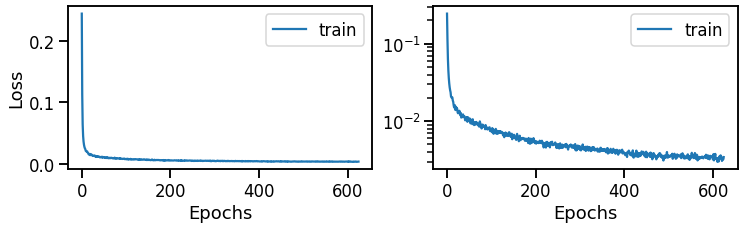

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

ax1.plot(L_train, label='train')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax1.legend()

ax2.semilogy(L_train, label='train')
ax2.set_xlabel('Epochs')
ax2.legend()

plt.show()

## Save/load model

At this point, you can opt to save the trained model. Or, if you have previously trained and saved a model, you can skip the training and load the trained model here.

There are two pre-trained models available: one for BCC/FCC/HCP and one for SiO2 (quartz and cristobalites). To load them, you might need to have the right versions of PyG (2.0.4) and PyTorch (1.11.0).

In [7]:
# Save
# torch.save(model, './models/Cu-denoiser.pt')

# Load
model = torch.load('./models/Cu-denoiser.pt')

## Denoise test data

In the case that the model was trained with Cu systems, it is still applicable to systems of other elements. You just have to scale the input data to match the atomic radius or the interatomic distance of the ideal Cu lattices. I used the following scaling factors:
- In-house data
    - Cu: 1.0
    - Ta: 0.82
- Benchmark data from Chung et al. (*"Data-centric framework for crystal structure identification in atomistic simulations using machine learning"*)
    - Al (FCC): 0.9
    - Ar (FCC): 0.65
    - Fe (BCC): 0.9
    - Li (BCC): 0.75
    - Mg (HCP): 0.75
    - Ti (HCP): 0.8

### Helper function for denoising

In [8]:
from graphite.transforms.radius_graph_ase import RadiusGraph_ase
from tqdm.notebook import trange

pos2graph = RadiusGraph_ase(cutoff=CUTOFF)

@torch.no_grad()
def denoise_snapshot(atoms, model, scale=1.0, steps=8):
    pos_traj = [atoms.positions]
    
    data = atoms2pygdata(atoms, ase=True)
    data.pos  *= scale
    data.cell *= scale
    
    for _ in trange(steps):
        data = pos2graph(data)
        disp = model(data)
        data.pos -= disp
        pos_traj.append(data.pos.clone().numpy() / scale)
    
    return pos_traj

### Denoise a perturbed FCC snapshot

You can also apply the model to other structures. Just change `TEST_FNAME` to a different structure file.

In [14]:
from pathlib import Path

TEST_FNAME = './data/Cu/3400K-fcc.dump'
path = Path(TEST_FNAME)

# Read perturbed data
noisy_atoms = ase.io.read(path)

# Get denoising trajectory (positions only)
model = model.to('cpu')
pos_traj = denoise_snapshot(noisy_atoms, model, scale=1.0, steps=8)

# Construct the denoising trajectory including other information (chemical symbols, cell dimenisons, etc.)
denoising_traj = [
    ase.Atoms(
        symbols   = noisy_atoms.get_chemical_symbols(),
        positions = pos,
        cell      = noisy_atoms.cell,
        pbc       = True
    )
    for pos in pos_traj
]

# Wrap the atoms into the simulaiton box
for atoms in denoising_traj: atoms.wrap()

# Save the denoising steps
ase.io.write(path.with_suffix('.denoised.extxyz'), denoising_traj)

Denoising:   0%|          | 0/8 [00:00<?, ?it/s]

Here is the denoising result (along the denoising iterations):

![denoising-fcc-3d](./media/denoising-fcc-3d.gif)

Here is the same result but in 2D view:

![denoising-fcc-2d](./media/denoising-fcc-2d.gif)

Note that the atoms are colored by a-CNA prediction (see the color legend).

### Denoise SiO2 β-quartz

You can re-run some of the cell blocks above to load the SiO2 denoiser and apply it to perturbed β-quartz. The denoising trajectory is shown below:

![denoising-b-quartz-2d](./media/denoising-b-quartz-2d.gif)

![denoising-b-quartz-3d](./media/denoising-b-quartz-3d.gif)

The silicon atoms are colored in beige, and the oxygens in red.

## Thank you!

This wraps up the demonstration for denoising MD-perturbed atomic structures. Large structure files that take up space are not stored in this git repository. Please contact the authors of this work if you wish to access the large-scale data discussed in the paper. Please also let us know if you have any questions. Thank you!